# 1) Install Required Libraries

In [1]:
!pip install transformers torch scikit-learn evaluate pandas xgboost joblib tqdm matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.7 MB/s eta 0:00:00


# 2) Import Libraries

In [2]:
import os
import numpy as np
import pandas as pd
import torch
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from xgboost import XGBClassifier, plot_importance
from sklearn.feature_extraction.text import TfidfVectorizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# 3) Configuration & Paths

Adjust file paths and hyperparameters as needed.

In [3]:
use_sample_data = True
sample_file_path = "/kaggle/input/balanced-yelp-100000/balanced_yelp_100000.json"
real_file_path = "/kaggle/input/yelp-dataset/yelp_academic_dataset_review.json"
file_path = sample_file_path if use_sample_data else real_file_path

print(f"✅ Dataset: {file_path}")

distilbert_save_path = "/kaggle/working/distilbert_model"  # where we save the DistilBERT weights
tfidf_vectorizer_path = "/kaggle/working/tfidf_vectorizer.pkl"
xgb_model_path = "/kaggle/working/xgb_hybrid.pkl"

# For DistilBERT training
num_labels = 5  
num_train_epochs = 3
test_size = 0.2
random_seed = 42

✅ Dataset: /kaggle/input/balanced-yelp-100000/balanced_yelp_100000.json


# 4) Load Data

We assume the Yelp data with columns "text" and "stars".
We'll convert stars to 0-based indexing so that DistilBertForSequenceClassification(num_labels=5) matches.

In [4]:
df_full = pd.read_json(file_path, lines=True)
df_full = df_full[['text', 'stars']].dropna()
df_full['stars'] = df_full['stars'].astype(int) - 1  # [1..5] => [0..4]

print("Data shape:", df_full.shape)
print(df_full.head())

Data shape: (100000, 2)
                                                text  stars
0  I went in today and tried the make your own Sa...      3
1  This place overall probably one of the best ch...      4
2  Looked for a recommended place as we were trav...      0
3  Excellent meal! We shared a very nice size por...      3
4  Good service, excellent food and presentation....      4


# 5) Single Train/Test Split

This split is used for BOTH DistilBERT and XGBoost.

In [5]:
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_full['text'].tolist(), 
    df_full['stars'].tolist(),
    test_size=test_size,
    random_state=random_seed,
    shuffle=True
)

print(f"Train size: {len(train_texts)}, Test size: {len(test_texts)}")

Train size: 80000, Test size: 20000


# 6) DistilBERT Training

We'll fine-tune DistilBERT on the training portion. We'll evaluate on the test portion.

In [6]:
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")

# 6.1: Tokenize
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=256)

class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

train_dataset = ReviewDataset(train_encodings, train_labels)
test_dataset = ReviewDataset(test_encodings, test_labels)

model = DistilBertForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=num_labels
)

training_args = TrainingArguments(
    output_dir=distilbert_save_path,
    num_train_epochs=num_train_epochs,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=distilbert_save_path,
    logging_steps=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    report_to="none",
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

# Save DistilBERT
trainer.save_model(distilbert_save_path)
tokenizer.save_pretrained(distilbert_save_path)
print("DistilBERT fine-tuning complete and saved.")

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss
1,0.737000,0.690919
2,0.416500,0.540622
3,0.305400,0.550905


/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


DistilBERT fine-tuning complete and saved.


# 7) Extract DistilBERT Embeddings

Instead of final logits (5 dims), we'll take the last hidden state [CLS] embedding (768 dims) 
for a richer representation. This typically performs better in a hybrid pipeline.

In [7]:
# Reload the fine-tuned model in "evaluation" mode
# (We do this to illustrate that you'd typically load from disk.)
distilbert_model = DistilBertForSequenceClassification.from_pretrained(distilbert_save_path).to(device)
distilbert_model.eval()

def get_last_hidden_cls(texts, batch_size=64):
    all_embeddings = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        tokens = tokenizer(batch_texts, truncation=True, padding=True, max_length=256, return_tensors="pt").to(device)

        with torch.no_grad():
            outputs = distilbert_model(
                **tokens,
                output_hidden_states=True,  # we want hidden states
                return_dict=True
            )
            # outputs.hidden_states[-1].shape => (batch_size, seq_len, hidden_size=768)
            last_hidden = outputs.hidden_states[-1]
            cls_embeds = last_hidden[:, 0, :].cpu().numpy()  # (batch_size, 768)
        
        all_embeddings.append(cls_embeds)

    return np.vstack(all_embeddings)  # shape: (N, 768)

print("Extracting DistilBERT embeddings for train set...")
train_embeddings = get_last_hidden_cls(train_texts)

print("Extracting DistilBERT embeddings for test set...")
test_embeddings = get_last_hidden_cls(test_texts)

print("Train embeddings shape:", train_embeddings.shape)
print("Test embeddings shape:", test_embeddings.shape)

Extracting DistilBERT embeddings for train set...
Extracting DistilBERT embeddings for test set...
Train embeddings shape: (80000, 768)
Test embeddings shape: (20000, 768)


# 8) TF-IDF for Train & Test

Fit on train texts, transform test texts to ensure no data leakage.

In [8]:
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(train_texts).toarray()
X_test_tfidf = vectorizer.transform(test_texts).toarray()

print("TF-IDF train shape:", X_train_tfidf.shape)
print("TF-IDF test shape:", X_test_tfidf.shape)

# Save vectorizer for inference
joblib.dump(vectorizer, tfidf_vectorizer_path)
print(f"TF-IDF vectorizer saved to {tfidf_vectorizer_path}.")

TF-IDF train shape: (80000, 5000)
TF-IDF test shape: (20000, 5000)
TF-IDF vectorizer saved to /kaggle/working/tfidf_vectorizer.pkl.


# 9) Combine DistilBERT + TF-IDF => XGBoost

In [9]:
X_train_combined = np.hstack([train_embeddings, X_train_tfidf])  
X_test_combined = np.hstack([test_embeddings, X_test_tfidf])

print("Combined train shape:", X_train_combined.shape)
print("Combined test shape: ", X_test_combined.shape)

xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=random_seed,
    use_label_encoder=False
)

xgb_model.fit(
    X_train_combined, 
    np.array(train_labels),
    eval_set=[(X_test_combined, np.array(test_labels))],
    early_stopping_rounds=10,
    verbose=True
)

y_pred = xgb_model.predict(X_test_combined)
acc = accuracy_score(test_labels, y_pred)
f1 = f1_score(test_labels, y_pred, average="weighted")

print("\n🎯 **Hybrid Model Results**")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")

# Save XGBoost
joblib.dump(xgb_model, xgb_model_path)
print(f"XGBoost hybrid model saved to {xgb_model_path}.")

Combined train shape: (80000, 5768)
Combined test shape:  (20000, 5768)


/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.44600
[1]	validation_0-mlogloss:1.31843
[2]	validation_0-mlogloss:1.21516
[3]	validation_0-mlogloss:1.12914
[4]	validation_0-mlogloss:1.05636
[5]	validation_0-mlogloss:0.99437
[6]	validation_0-mlogloss:0.94056
[7]	validation_0-mlogloss:0.89414
[8]	validation_0-mlogloss:0.85378
[9]	validation_0-mlogloss:0.81840
[10]	validation_0-mlogloss:0.78753
[11]	validation_0-mlogloss:0.76059
[12]	validation_0-mlogloss:0.73694
[13]	validation_0-mlogloss:0.71612
[14]	validation_0-mlogloss:0.69786
[15]	validation_0-mlogloss:0.68172
[16]	validation_0-mlogloss:0.66756
[17]	validation_0-mlogloss:0.65508
[18]	validation_0-mlogloss:0.64409
[19]	validation_0-mlogloss:0.63451
[20]	validation_0-mlogloss:0.62621
[21]	validation_0-mlogloss:0.61885
[22]	validation_0-mlogloss:0.61237
[23]	validation_0-mlogloss:0.60670
[24]	validation_0-mlogloss:0.60185
[25]	validation_0-mlogloss:0.59750
[26]	validation_0-mlogloss:0.59370
[27]	validation_0-mlogloss:0.59043
[28]	validation_0-mlogloss:0.5

# 10) Optional: Plot Training Loss & Feature Importance

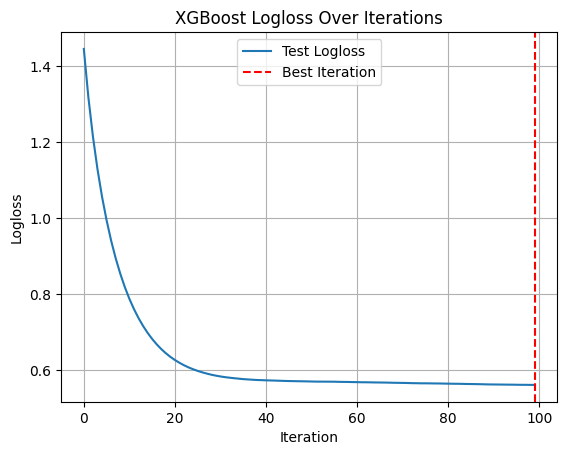

<Figure size 800x600 with 0 Axes>

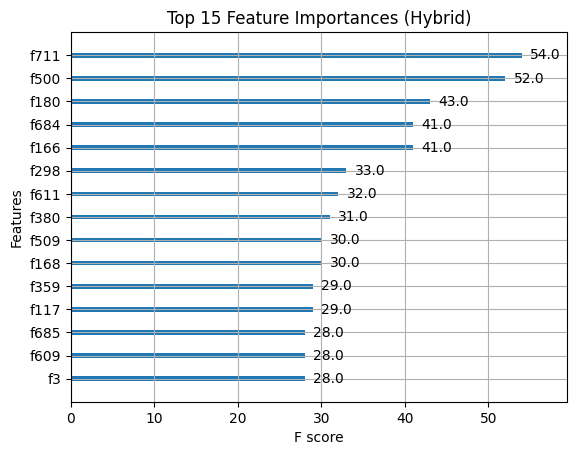

In [10]:
# Evals result
evals_result = xgb_model.evals_result()
epochs = len(evals_result['validation_0']['mlogloss'])
plt.plot(range(epochs), evals_result['validation_0']['mlogloss'], label='Test Logloss')
plt.axvline(x=xgb_model.best_iteration, color='red', linestyle='--', label="Best Iteration")
plt.xlabel('Iteration')
plt.ylabel('Logloss')
plt.title('XGBoost Logloss Over Iterations')
plt.legend()
plt.grid(True)
plt.show()

# Feature importance
plt.figure(figsize=(8,6))
plot_importance(xgb_model, max_num_features=15)
plt.title("Top 15 Feature Importances (Hybrid)")
plt.show()

# 11) Final Artifacts
We can store model artifacts in a dictionary, or keep them separate.

In [11]:
model_artifacts = {
    "xgb_model": xgb_model,
    "tfidf_vectorizer": vectorizer,
    "distilbert_path": distilbert_save_path,  # path to the DistilBERT checkpoint
    "accuracy": acc,
    "f1_score": f1,
}

joblib.dump(model_artifacts, xgb_model_path)
print(f"✅ Final artifacts saved to {xgb_model_path}!\n")
print(f"Accuracy: {acc*100:.2f}% | F1 Score: {f1:.4f}")

✅ Final artifacts saved to /kaggle/working/xgb_hybrid.pkl!

Accuracy: 80.31% | F1 Score: 0.8023
